# TASK 1.1,1.2


--- Chartist Summary ---
Momentum Heavy:
  Positions Opened: 11
  Positions Closed: 11
  Final GBP: 7969.63
  Final BTC: 10.000000

RSI Heavy:
  Positions Opened: 30
  Positions Closed: 29
  Final GBP: 0.00
  Final BTC: 11.847709

Balanced:
  Positions Opened: 26
  Positions Closed: 26
  Final GBP: 13691.82
  Final BTC: 10.000000

Volatility Based:
  Positions Opened: 1
  Positions Closed: 0
  Final GBP: 0.00
  Final BTC: 11.385694

--- Random Trader Summary ---
Positions Opened: 459
Positions Closed: 453
Final GBP: 50910.82
Final BTC: 108.492460



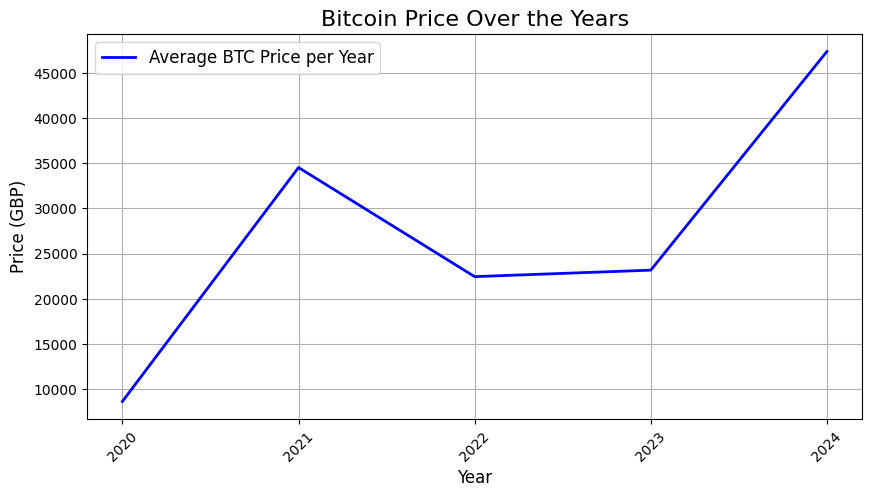

In [10]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

data = pd.read_csv('/content/BTC to GBP Historical Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.sort_values(by='Date', inplace=True)

data['Price'] = data['Price'].replace(',', '', regex=True)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

data = data.dropna(subset=['Price'])

data['Daily_Return'] = data['Price'].pct_change()
data['14-day RSI'] = 100 - (100 / (1 + data['Daily_Return'].rolling(14).mean() /
                                    abs(data['Daily_Return'].rolling(14).mean())))
# Constants
NUM_AGENTS = 100  # Total number of agents
INIT_BITCOIN = 10  # Initial BTC per agent
INIT_GBP = 10000   # Initial GBP per agent
BITCOIN_ISSUANCE_INTERVAL = 90  # Days
BITCOIN_ISSUANCE_RATE = 0.1  # 10%
VOLATILITY_THRESHOLD = 2.5  # Weekly standard deviation threshold

# Initialize agents
agents = [{'GBP': INIT_GBP, 'BTC': INIT_BITCOIN, 'positions': []} for _ in range(NUM_AGENTS)]

class MarketEnvironment:
    """Simulates the market environment, including Bitcoin issuance."""
    def __init__(self, agents):
        self.agents = agents
        self.total_bitcoin = INIT_BITCOIN * len(agents)
        self.days = 0

    def distribute_new_bitcoin(self):
        """Distribute newly issued Bitcoin to agents based on their existing holdings."""
        new_bitcoin = self.total_bitcoin * BITCOIN_ISSUANCE_RATE
        self.total_bitcoin += new_bitcoin

        total_agent_btc = sum(agent['BTC'] for agent in self.agents)
        for agent in self.agents:
            if total_agent_btc > 0:
                agent['BTC'] += new_bitcoin * (agent['BTC'] / total_agent_btc)

    def simulate_bitcoin_issuance(self):
        """Issue Bitcoin every 90 days."""
        if self.days > 0 and self.days % BITCOIN_ISSUANCE_INTERVAL == 0:
            self.distribute_new_bitcoin()

class Chartist:
    """Represents a Chartist agent with trading strategies."""
    def __init__(self, weight_momentum, weight_rsi, name):
        self.weight_momentum = weight_momentum
        self.weight_rsi = weight_rsi
        self.name = name
        self.open_position = False
        self.btc_holdings = INIT_BITCOIN
        self.gbp_holdings = INIT_GBP
        self.position_btc = 0

    def decide(self, price_data, day):
        """Decide whether to open or close a position based on trading rules."""
        if day < 14:  # Not enough data for RSI
            return False, False

        # Momentum-based rule
        momentum_signal = all(price_data['Price'].iloc[day-3:day].diff().dropna() > 0)

        # RSI-based rule
        rsi_signal = price_data['14-day RSI'].iloc[day]

        # Combine decisions based on weights
        open_decision = momentum_signal if random.uniform(0, 1) < self.weight_momentum else rsi_signal < 30
        close_decision = not momentum_signal if random.uniform(0, 1) < self.weight_rsi else rsi_signal > 70

        return open_decision, close_decision

    def trade(self, open_decision, close_decision, price):
        """Execute trades based on decisions."""
        if open_decision and not self.open_position:
            # Open position
            btc_bought = self.gbp_holdings / price
            self.position_btc = btc_bought
            self.btc_holdings += btc_bought
            self.gbp_holdings = 0
            self.open_position = True
        elif close_decision and self.open_position:
            # Close position
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False

chartists = [
    Chartist(0.8, 0.2, 'Momentum Heavy'),
    Chartist(0.2, 0.8, 'RSI Heavy'),
    Chartist(0.5, 0.5, 'Balanced'),
    Chartist(1, 0, 'Volatility Based'),
]

class RandomTrader:
    """Represents a Random Trader agent."""
    def __init__(self):
        self.open_position = False
        self.btc_holdings = INIT_BITCOIN
        self.gbp_holdings = INIT_GBP
        self.position_btc = 0

    def decide(self):
        """Randomly decide to open or close a position."""
        return random.choice([True, False]), random.choice([True, False])

    def trade(self, open_decision, close_decision, price):
      if open_decision and not self.open_position:
          # Open position (use all GBP to buy BTC)
          btc_bought = self.gbp_holdings / price
          self.position_btc = btc_bought
          self.btc_holdings += btc_bought
          self.gbp_holdings = 0  # All GBP is used to buy Bitcoin
          self.open_position = True
      elif close_decision and self.open_position:
          # Close position (convert all BTC back to GBP)
          gbp_sold = self.position_btc * price
          self.gbp_holdings += gbp_sold
          self.btc_holdings -= self.position_btc
          self.position_btc = 0
          self.open_position = False

random_traders = [RandomTrader() for _ in range(10)]

def simulate_market_with_output(days=180):
    """Simulate the market and track performance of agents."""
    market = MarketEnvironment(agents)
    chartist_summary = {chartist.name: {"positions_opened": 0, "positions_closed": 0, "final_gbp": 0, "final_btc": 0} for chartist in chartists}
    random_trader_summary = {"positions_opened": 0, "positions_closed": 0, "final_gbp": 0, "final_btc": 0}
    btc_prices = []

    for day in range(days):
        price = data['Price'].iloc[day]
        btc_prices.append(price)

        for chartist in chartists:
            open_decision, close_decision = chartist.decide(data, day)
            if open_decision and not chartist.open_position:
                chartist_summary[chartist.name]["positions_opened"] += 1
            if close_decision and chartist.open_position:
                chartist_summary[chartist.name]["positions_closed"] += 1
            chartist.trade(open_decision, close_decision, price)

        for random_trader in random_traders:
            open_decision, close_decision = random_trader.decide()
            if open_decision and not random_trader.open_position:
                random_trader_summary["positions_opened"] += 1
            if close_decision and random_trader.open_position:
                random_trader_summary["positions_closed"] += 1
            random_trader.trade(open_decision, close_decision, price)
        market.days += 1
        market.simulate_bitcoin_issuance()

    for chartist in chartists:
        chartist_summary[chartist.name]["final_gbp"] = chartist.gbp_holdings
        chartist_summary[chartist.name]["final_btc"] = chartist.btc_holdings

    random_trader_summary["final_gbp"] = sum(rt.gbp_holdings for rt in random_traders)
    random_trader_summary["final_btc"] = sum(rt.btc_holdings for rt in random_traders)

    return chartist_summary, random_trader_summary, btc_prices

chartist_summary, random_trader_summary, btc_prices = simulate_market_with_output(180)

print("\n--- Chartist Summary ---")
for name, summary in chartist_summary.items():
    print(f"{name}:")
    print(f"  Positions Opened: {summary['positions_opened']}")
    print(f"  Positions Closed: {summary['positions_closed']}")
    print(f"  Final GBP: {summary['final_gbp']:.2f}")
    print(f"  Final BTC: {summary['final_btc']:.6f}\n")

print("--- Random Trader Summary ---")
print(f"Positions Opened: {random_trader_summary['positions_opened']}")
print(f"Positions Closed: {random_trader_summary['positions_closed']}")
print(f"Final GBP: {random_trader_summary['final_gbp']:.2f}")
print(f"Final BTC: {random_trader_summary['final_btc']:.6f}\n")

years = data['Date'].dt.year.unique()
btc_prices_per_year = []

for year in years:
    year_prices = data[data['Date'].dt.year == year]['Price']
    btc_prices_per_year.append(year_prices.mean())

plt.figure(figsize=(10, 5))
plt.plot(years, btc_prices_per_year, label="Average BTC Price per Year", color="blue", linewidth=2)
plt.title("Bitcoin Price Over the Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Price (GBP)", fontsize=12)
plt.xticks(years, rotation=45)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# TASK 1.3

In [2]:
class MarketEnvironmentPetrov:
    """Simulates the market environment, including Bitcoin issuance and price updates."""
    def __init__(self, agents, alpha=0.5):
        self.agents = agents
        self.total_bitcoin = INIT_BITCOIN * len(agents)
        self.days = 0
        self.price = data['Price'].iloc[0]
        self.alpha = alpha

    def distribute_new_bitcoin(self):
        """Distribute newly issued Bitcoin to agents based on their existing holdings."""
        new_bitcoin = self.total_bitcoin * BITCOIN_ISSUANCE_RATE
        self.total_bitcoin += new_bitcoin

        total_agent_btc = sum(agent['BTC'] for agent in self.agents)
        for agent in self.agents:
            if total_agent_btc > 0:
                agent['BTC'] += new_bitcoin * (agent['BTC'] / total_agent_btc)

    def calculate_net_demand(self):
        """Calculate the net demand in the market (sum of agent actions)."""
        net_demand = 0
        for agent in self.agents:
            if isinstance(agent, (Chartist, RandomTrader)):
                if agent.open_position:
                    net_demand -= agent.position_btc
                else:
                    net_demand += agent.gbp_holdings / self.price
        return net_demand

    def update_price(self, net_demand):
        """Update the market price using Petrov's price response function."""
        # Petrov's price response function
        price_change = np.floor(self.alpha * np.sign(net_demand) * np.sqrt(abs(net_demand)))
        self.price += price_change
        self.price = max(self.price, 1)

    def simulate_bitcoin_issuance(self):
        """Issue Bitcoin every 90 days."""
        if self.days > 0 and self.days % BITCOIN_ISSUANCE_INTERVAL == 0:
            self.distribute_new_bitcoin()

def simulate_market_with_price_response(days=180):
    """Simulate the market with Petrov’s price response function."""
    market = MarketEnvironmentPetrov(agents)
    chartist_summary = {chartist.name: {"positions_opened": 0, "positions_closed": 0, "final_gbp": 0, "final_btc": 0} for chartist in chartists}
    random_trader_summary = {"positions_opened": 0, "positions_closed": 0, "final_gbp": 0, "final_btc": 0}
    btc_prices = []

    for day in range(days):
        net_demand = market.calculate_net_demand()
        market.update_price(net_demand)
        btc_prices.append(market.price)

        for chartist in chartists:
            open_decision, close_decision = chartist.decide(data, day)
            if open_decision and not chartist.open_position:
                chartist_summary[chartist.name]["positions_opened"] += 1
            if close_decision and chartist.open_position:
                chartist_summary[chartist.name]["positions_closed"] += 1
            chartist.trade(open_decision, close_decision, market.price)

        for random_trader in random_traders:
            open_decision, close_decision = random_trader.decide()
            if open_decision and not random_trader.open_position:
                random_trader_summary["positions_opened"] += 1
            if close_decision and random_trader.open_position:
                random_trader_summary["positions_closed"] += 1
            random_trader.trade(open_decision, close_decision, market.price)

        market.days += 1
        market.simulate_bitcoin_issuance()

    for chartist in chartists:
        chartist_summary[chartist.name]["final_gbp"] = chartist.gbp_holdings
        chartist_summary[chartist.name]["final_btc"] = chartist.btc_holdings

    random_trader_summary["final_gbp"] = sum(rt.gbp_holdings for rt in random_traders)
    random_trader_summary["final_btc"] = sum(rt.btc_holdings for rt in random_traders)

    return chartist_summary, random_trader_summary, btc_prices

chartist_summary, random_trader_summary, btc_prices = simulate_market_with_price_response(180)

print("\n--- Chartist Summary ---")
for name, summary in chartist_summary.items():
    print(f"{name}:")
    print(f"  Positions Opened: {summary['positions_opened']}")
    print(f"  Positions Closed: {summary['positions_closed']}")
    print(f"  Final GBP: {summary['final_gbp']:.2f}")
    print(f"  Final BTC: {summary['final_btc']:.6f}\n")

print("--- Random Trader Summary ---")
print(f"Positions Opened: {random_trader_summary['positions_opened']}")
print(f"Positions Closed: {random_trader_summary['positions_closed']}")
print(f"Final GBP: {random_trader_summary['final_gbp']:.2f}")
print(f"Final BTC: {random_trader_summary['final_btc']:.6f}\n")





--- Chartist Summary ---
Momentum Heavy:
  Positions Opened: 15
  Positions Closed: 15
  Final GBP: 7969.63
  Final BTC: 10.000000

RSI Heavy:
  Positions Opened: 28
  Positions Closed: 29
  Final GBP: 10018.65
  Final BTC: 10.000000

Balanced:
  Positions Opened: 24
  Positions Closed: 23
  Final GBP: 0.00
  Final BTC: 12.525141

Volatility Based:
  Positions Opened: 0
  Positions Closed: 0
  Final GBP: 0.00
  Final BTC: 11.385694

--- Random Trader Summary ---
Positions Opened: 442
Positions Closed: 442
Final GBP: 39363.56
Final BTC: 110.622086



# TASK 2.1

Simulation for 90 days:

--- Chartist Summary ---
Momentum Heavy:
  Positions Opened: 7
  Positions Closed: 7
  Final GBP: 4435.94
  Final BTC: 10.000000

RSI Heavy:
  Positions Opened: 13
  Positions Closed: 14
  Final GBP: 12008.11
  Final BTC: 10.000000

Balanced:
  Positions Opened: 10
  Positions Closed: 10
  Final GBP: 13560.95
  Final BTC: 10.000000

Volatility Based:
  Positions Opened: 0
  Positions Closed: 0
  Final GBP: 0.00
  Final BTC: 11.385694

--- Random Trader Summary ---
Positions Opened: 211
Positions Closed: 210
Final GBP: 40534.55
Final BTC: 110.814876

Total Trades by Chartists: 61
Total Trades by Random Traders: 421
--------------------------------------------------


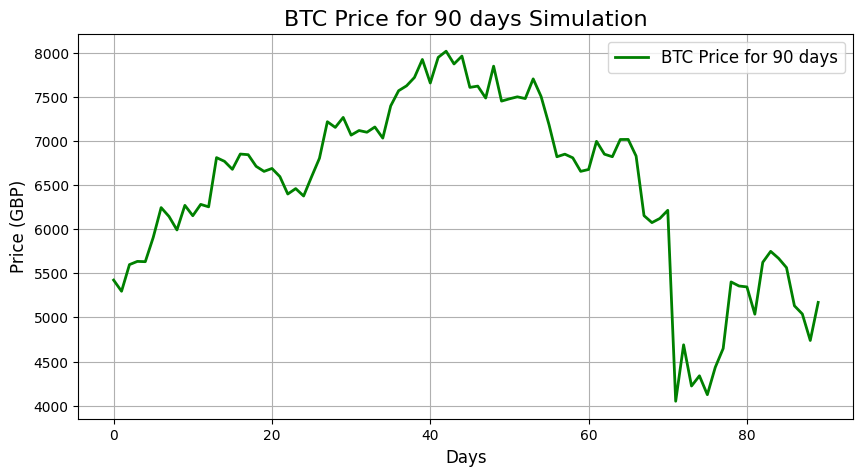

Simulation for 180 days:

--- Chartist Summary ---
Momentum Heavy:
  Positions Opened: 18
  Positions Closed: 17
  Final GBP: 0.00
  Final BTC: 10.392857

RSI Heavy:
  Positions Opened: 28
  Positions Closed: 27
  Final GBP: 0.00
  Final BTC: 11.985789

Balanced:
  Positions Opened: 24
  Positions Closed: 24
  Final GBP: 12372.35
  Final BTC: 10.000000

Volatility Based:
  Positions Opened: 0
  Positions Closed: 0
  Final GBP: 0.00
  Final BTC: 11.385694

--- Random Trader Summary ---
Positions Opened: 445
Positions Closed: 447
Final GBP: 60243.64
Final BTC: 111.358493

Total Trades by Chartists: 138
Total Trades by Random Traders: 892
--------------------------------------------------


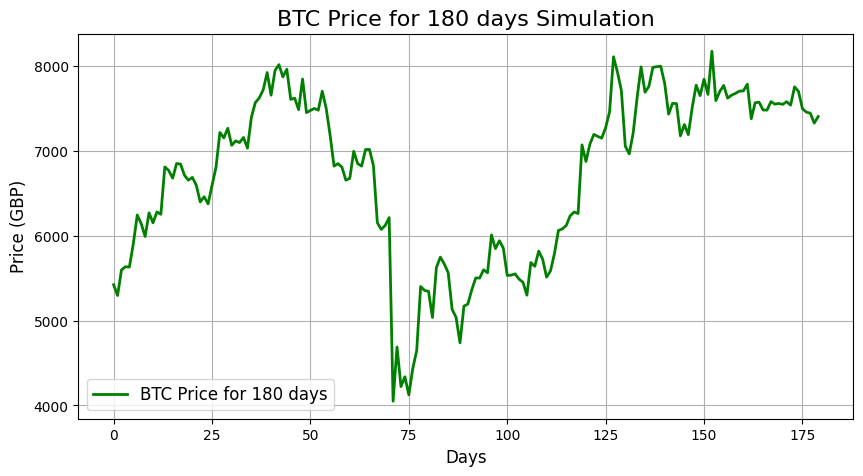

Simulation for 365 days:

--- Chartist Summary ---
Momentum Heavy:
  Positions Opened: 36
  Positions Closed: 36
  Final GBP: 0.00
  Final BTC: 10.318918

RSI Heavy:
  Positions Opened: 59
  Positions Closed: 60
  Final GBP: 25719.06
  Final BTC: 10.000000

Balanced:
  Positions Opened: 58
  Positions Closed: 57
  Final GBP: 0.00
  Final BTC: 11.145632

Volatility Based:
  Positions Opened: 0
  Positions Closed: 0
  Final GBP: 0.00
  Final BTC: 11.385694

--- Random Trader Summary ---
Positions Opened: 955
Positions Closed: 952
Final GBP: 47727.29
Final BTC: 109.681332

Total Trades by Chartists: 306
Total Trades by Random Traders: 1907
--------------------------------------------------


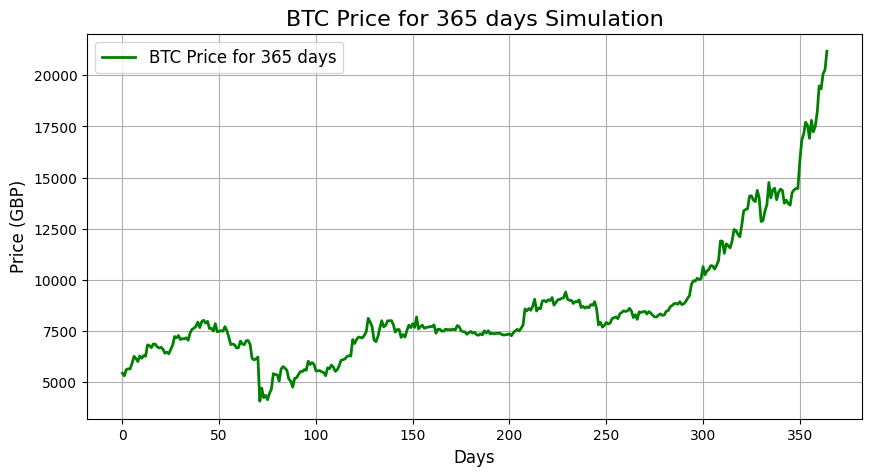

Simulation for 1766 days:

--- Chartist Summary ---
Momentum Heavy:
  Positions Opened: 153
  Positions Closed: 153
  Final GBP: 0.00
  Final BTC: 10.173704

RSI Heavy:
  Positions Opened: 358
  Positions Closed: 357
  Final GBP: 0.00
  Final BTC: 10.919263

Balanced:
  Positions Opened: 279
  Positions Closed: 279
  Final GBP: 0.00
  Final BTC: 10.553345

Volatility Based:
  Positions Opened: 0
  Positions Closed: 0
  Final GBP: 0.00
  Final BTC: 11.385694

--- Random Trader Summary ---
Positions Opened: 4403
Positions Closed: 4406
Final GBP: 76916.36
Final BTC: 103.599857

Total Trades by Chartists: 1579
Total Trades by Random Traders: 8809
--------------------------------------------------


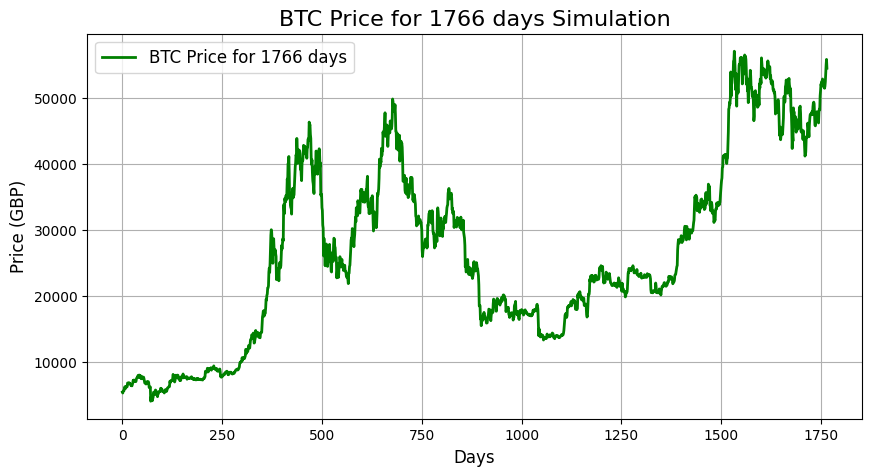

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

data = pd.read_csv('/content/BTC to GBP Historical Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.sort_values(by='Date', inplace=True)

data['Price'] = data['Price'].replace(',', '', regex=True)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

data = data[(data['Date'] >= '2020-01-01') & (data['Date'] <= '2024-11-01')]
data = data.dropna(subset=['Price'])
data['Daily_Return'] = data['Price'].pct_change()
data['14-day RSI'] = 100 - (100 / (1 + data['Daily_Return'].rolling(14).mean() /
                                    abs(data['Daily_Return'].rolling(14).mean())))

data = data.dropna(subset=['Price'])

data['Daily_Return'] = data['Price'].pct_change()
data['14-day RSI'] = 100 - (100 / (1 + data['Daily_Return'].rolling(14).mean() /
                                    abs(data['Daily_Return'].rolling(14).mean())))


NUM_AGENTS = 100
INIT_BITCOIN = 10
INIT_GBP = 10000
BITCOIN_ISSUANCE_INTERVAL = 90
BITCOIN_ISSUANCE_RATE = 0.1
VOLATILITY_THRESHOLD = 2.5

agents = [{'GBP': INIT_GBP, 'BTC': INIT_BITCOIN, 'positions': []} for _ in range(NUM_AGENTS)]

class MarketEnvironmentPetrov:
    """Simulates the market environment, including Bitcoin issuance."""
    def __init__(self, agents):
        self.agents = agents
        self.total_bitcoin = INIT_BITCOIN * len(agents)
        self.days = 0

    def distribute_new_bitcoin(self):
        """Distribute newly issued Bitcoin to agents based on their existing holdings."""
        new_bitcoin = self.total_bitcoin * BITCOIN_ISSUANCE_RATE
        self.total_bitcoin += new_bitcoin

        total_agent_btc = sum(agent['BTC'] for agent in self.agents)
        for agent in self.agents:
            if total_agent_btc > 0:
                agent['BTC'] += new_bitcoin * (agent['BTC'] / total_agent_btc)

    def simulate_bitcoin_issuance(self):
        """Issue Bitcoin every 90 days."""
        if self.days > 0 and self.days % BITCOIN_ISSUANCE_INTERVAL == 0:
            self.distribute_new_bitcoin()

class Chartist:
    """Represents a Chartist agent with trading strategies."""
    def __init__(self, weight_momentum, weight_rsi, name):
        self.weight_momentum = weight_momentum
        self.weight_rsi = weight_rsi
        self.name = name
        self.open_position = False
        self.btc_holdings = INIT_BITCOIN
        self.gbp_holdings = INIT_GBP
        self.position_btc = 0

    def decide(self, price_data, day):
        """Decide whether to open or close a position based on trading rules."""
        if day < 14:
            return False, False

        # Momentum-based rule
        momentum_signal = all(price_data['Price'].iloc[day-3:day].diff().dropna() > 0)

        # RSI-based rule
        rsi_signal = price_data['14-day RSI'].iloc[day]

        # Combine decisions based on weights
        open_decision = momentum_signal if random.uniform(0, 1) < self.weight_momentum else rsi_signal < 30
        close_decision = not momentum_signal if random.uniform(0, 1) < self.weight_rsi else rsi_signal > 70

        return open_decision, close_decision

    def trade(self, open_decision, close_decision, price):
        """Execute trades based on decisions."""
        if open_decision and not self.open_position:
            # Open position
            btc_bought = self.gbp_holdings / price
            self.position_btc = btc_bought
            self.btc_holdings += btc_bought
            self.gbp_holdings = 0
            self.open_position = True
        elif close_decision and self.open_position:
            # Close position
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False

chartists = [
    Chartist(0.8, 0.2, 'Momentum Heavy'),
    Chartist(0.2, 0.8, 'RSI Heavy'),
    Chartist(0.5, 0.5, 'Balanced'),
    Chartist(1, 0, 'Volatility Based'),
]

class RandomTrader:
    """Represents a Random Trader agent."""
    def __init__(self):
        self.open_position = False
        self.btc_holdings = INIT_BITCOIN
        self.gbp_holdings = INIT_GBP
        self.position_btc = 0

    def decide(self):
        """Randomly decide to open or close a position."""
        return random.choice([True, False]), random.choice([True, False])

    def trade(self, open_decision, close_decision, price):
      if open_decision and not self.open_position:
          # Open position (use all GBP to buy BTC)
          btc_bought = self.gbp_holdings / price
          self.position_btc = btc_bought
          self.btc_holdings += btc_bought
          self.gbp_holdings = 0  # All GBP is used to buy Bitcoin
          self.open_position = True
      elif close_decision and self.open_position:
          # Close position (convert all BTC back to GBP)
          gbp_sold = self.position_btc * price
          self.gbp_holdings += gbp_sold
          self.btc_holdings -= self.position_btc
          self.position_btc = 0
          self.open_position = False

random_traders = [RandomTrader() for _ in range(10)]

def simulate_market_with_output(days=180):
    """Simulate the market and track performance of agents."""
    market = MarketEnvironmentPetrov(agents)
    chartist_summary = {chartist.name: {"positions_opened": 0, "positions_closed": 0, "final_gbp": 0, "final_btc": 0} for chartist in chartists}
    random_trader_summary = {"positions_opened": 0, "positions_closed": 0, "final_gbp": 0, "final_btc": 0}
    btc_prices = []

    for day in range(days):
        price = data['Price'].iloc[day]
        btc_prices.append(price)

        # Update chartists
        for chartist in chartists:
            open_decision, close_decision = chartist.decide(data, day)
            if open_decision and not chartist.open_position:
                chartist_summary[chartist.name]["positions_opened"] += 1
            if close_decision and chartist.open_position:
                chartist_summary[chartist.name]["positions_closed"] += 1
            chartist.trade(open_decision, close_decision, price)

        # Update random traders
        for random_trader in random_traders:
            open_decision, close_decision = random_trader.decide()
            if open_decision and not random_trader.open_position:
                random_trader_summary["positions_opened"] += 1
            if close_decision and random_trader.open_position:
                random_trader_summary["positions_closed"] += 1
            random_trader.trade(open_decision, close_decision, price)

        # Simulate Bitcoin issuance every 90 days
        market.days += 1
        market.simulate_bitcoin_issuance()

    for chartist in chartists:
        chartist_summary[chartist.name]["final_gbp"] = chartist.gbp_holdings
        chartist_summary[chartist.name]["final_btc"] = chartist.btc_holdings

    random_trader_summary["final_gbp"] = sum(rt.gbp_holdings for rt in random_traders)
    random_trader_summary["final_btc"] = sum(rt.btc_holdings for rt in random_traders)

    return chartist_summary, random_trader_summary, btc_prices


chartist_summary, random_trader_summary, btc_prices = simulate_market_with_output(180)

# Run simulations for different periods (90 days, 180 days, 365 days, 1766 days(total days))
for n in [90, 180, 365,1766]:
    chartist_summary, random_trader_summary, btc_prices = simulate_market_with_output(n)
    print(f"Simulation for {n} days:")

    # Display Chartist summaries
    print("\n--- Chartist Summary ---")
    for name, summary in chartist_summary.items():
        print(f"{name}:")
        print(f"  Positions Opened: {summary['positions_opened']}")
        print(f"  Positions Closed: {summary['positions_closed']}")
        print(f"  Final GBP: {summary['final_gbp']:.2f}")
        print(f"  Final BTC: {summary['final_btc']:.6f}\n")

    # Display Random Trader summary
    print("--- Random Trader Summary ---")
    print(f"Positions Opened: {random_trader_summary['positions_opened']}")
    print(f"Positions Closed: {random_trader_summary['positions_closed']}")
    print(f"Final GBP: {random_trader_summary['final_gbp']:.2f}")
    print(f"Final BTC: {random_trader_summary['final_btc']:.6f}\n")

    # Optionally, analyze trade frequency and profitability
    print(f"Total Trades by Chartists: {sum(summary['positions_opened'] + summary['positions_closed'] for summary in chartist_summary.values())}")
    print(f"Total Trades by Random Traders: {random_trader_summary['positions_opened'] + random_trader_summary['positions_closed']}")
    print("-" * 50)

    # You could also visualize the BTC prices if you want
    plt.figure(figsize=(10, 5))
    plt.plot(btc_prices, label=f"BTC Price for {n} days", color="green", linewidth=2)
    plt.title(f"BTC Price for {n} days Simulation", fontsize=16)
    plt.xlabel("Days", fontsize=12)
    plt.ylabel("Price (GBP)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


# TASK 2.2

In [4]:
import csv
import pandas as pd

def simulate_market_and_log(days=1700):
    """Simulate the market and log daily performance metrics for each agent."""
    market = MarketEnvironment(agents)
    daily_log = []

    chartist_summary = {chartist.name: {"final_gbp": 0, "final_btc": 0} for chartist in chartists}
    random_trader_summary = {"final_gbp": 0, "final_btc": 0}

    btc_prices = []

    for day in range(days):
        price = data['Price'].iloc[day]
        btc_prices.append(price)

        for chartist in chartists:
            open_decision, close_decision = chartist.decide(data, day)
            chartist.trade(open_decision, close_decision, price)

            daily_log.append({
                "Date": data['Date'].iloc[day],
                "Agent_Type": "Chartist",
                "Subtype": chartist.name,
                "GBP_Holdings": chartist.gbp_holdings,
                "BTC_Holdings": chartist.btc_holdings,
                "Total_Wealth": chartist.gbp_holdings + chartist.btc_holdings * price,
                "Exposure": chartist.open_position,
                "Day": day,
                "Wins": 1 if open_decision == 1 and close_decision == -1 else 0,
                "Trades": 1
            })


        for random_trader in random_traders:
            open_decision, close_decision = random_trader.decide()
            random_trader.trade(open_decision, close_decision, price)
            daily_log.append({
                "Date": data['Date'].iloc[day],
                "Agent_Type": "Random Trader",
                "Subtype": "N/A",
                "GBP_Holdings": random_trader.gbp_holdings,
                "BTC_Holdings": random_trader.btc_holdings,
                "Total_Wealth": random_trader.gbp_holdings + random_trader.btc_holdings * price,
                "Exposure": random_trader.open_position,
                "Day": day,
                "Wins": 1 if open_decision == 1 and close_decision == -1 else 0,
                "Trades": 1
            })

        market.days += 1
        market.simulate_bitcoin_issuance()

    filename = "agent_daily_performance_task_2.2.csv"
    with open(filename, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=daily_log[0].keys())
        writer.writeheader()
        writer.writerows(daily_log)

    print(f"Daily performance metrics saved to {filename}")

simulate_market_and_log(1700)

file_path = '/content/agent_daily_performance_task_2.2.csv'
performance_data = pd.read_csv(file_path)

performance_data['Date'] = pd.to_datetime(performance_data['Date'])

performance_data = performance_data[
    (performance_data['Date'].dt.year >= 2020) & (performance_data['Date'].dt.year <= 2024)
]

def calculate_win_rate(data):
    """Calculate win rate for each agent."""
    return (data['Wins'].sum() / data['Trades'].sum()) * 100 if data['Trades'].sum() > 0 else 0

# Adding Trades and Wins Columns to the dataset
performance_data['Wins'] = performance_data['Exposure']  # Assuming exposure=1 indicates profitable trades
performance_data['Trades'] = 1  # Each row is a trade

# Group and calculate metrics
summary_metrics = performance_data.groupby(['Agent_Type', 'Subtype']).agg(
    Final_GBP=('GBP_Holdings', lambda x: x.iloc[-1]),
    Final_BTC=('BTC_Holdings', lambda x: x.iloc[-1]),
    Total_Wealth=('Total_Wealth', lambda x: x.iloc[-1]),
    Avg_Exposure_Time=('Exposure', 'mean'),  # Average exposure time
    Max_Drawdown=('Total_Wealth', lambda x: ((x.max() - x.min()) / x.max()) * 100 if x.max() > 0 else 0),
    Trades=('Trades', 'sum'),
    Wins=('Wins', 'sum')
).reset_index()

summary_metrics['GBP_to_BTC_Ratio'] = summary_metrics['Final_GBP'] / (summary_metrics['Final_BTC'] + 1e-10)  # Avoid division by zero
summary_metrics['Win_Rate'] = (summary_metrics['Wins'] / summary_metrics['Trades']) * 100
summary_metrics['Avg_Exposure_Time'] = summary_metrics['Avg_Exposure_Time'] * 100  # Convert to percentage

print("\n===== Summary Metrics for Chartists and Random Traders =====\n")
print(summary_metrics)

random_trader_metrics = performance_data[performance_data['Agent_Type'] == 'Random Trader'].groupby('Agent_Type').agg(
    Final_GBP=('GBP_Holdings', lambda x: x.iloc[-1]),
    Final_BTC=('BTC_Holdings', lambda x: x.iloc[-1]),
    Total_Wealth=('Total_Wealth', lambda x: x.iloc[-1]),
    Avg_Exposure_Time=('Exposure', 'mean'),
    Max_Drawdown=('Total_Wealth', lambda x: ((x.max() - x.min()) / x.max()) * 100 if x.max() > 0 else 0),
    Trades=('Trades', 'sum'),
    Wins=('Wins', 'sum')
).reset_index()

random_trader_metrics['GBP_to_BTC_Ratio'] = random_trader_metrics['Final_GBP'] / (random_trader_metrics['Final_BTC'] + 1e-10)
random_trader_metrics['Win_Rate'] = (random_trader_metrics['Wins'] / random_trader_metrics['Trades']) * 100
random_trader_metrics['Avg_Exposure_Time'] = random_trader_metrics['Avg_Exposure_Time'] * 100  # Convert to percentage

print("\n===== Summary Metrics for Random Traders =====\n")
print(random_trader_metrics)


Daily performance metrics saved to agent_daily_performance_task_2.2.csv

===== Summary Metrics for Chartists and Random Traders =====

  Agent_Type           Subtype    Final_GBP  Final_BTC   Total_Wealth  \
0   Chartist          Balanced     0.000000  10.129592  482701.389289   
1   Chartist    Momentum Heavy     0.000000  10.149062  483629.212953   
2   Chartist         RSI Heavy  5350.926105  10.000000  481876.926105   
3   Chartist  Volatility Based     0.000000  11.385694  542557.926392   

   Avg_Exposure_Time  Max_Drawdown  Trades  Wins  GBP_to_BTC_Ratio    Win_Rate  
0          46.058824     92.676545    1700   783          0.000000   46.058824  
1          63.117647     92.878025    1700  1073          0.000000   63.117647  
2          36.058824     92.367289    1700   613        535.092611   36.058824  
3         100.000000     92.897653    1700  1700          0.000000  100.000000  

===== Summary Metrics for Random Traders =====

      Agent_Type  Final_GBP  Final_BTC   Tota

# TASK 3.2

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/BTC to GBP Historical Data.csv')

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

data.sort_values(by='Date', inplace=True)

data['Price'] = data['Price'].replace(',', '', regex=True)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

data = data[(data['Date'] >= '2020-01-01') & (data['Date'] <= '2024-11-01')]

data['Log_Return'] = np.log(data['Price'] / data['Price'].shift(1))

print(data[['Date', 'Price', 'Log_Return']].head(10))

output_file = '/content/BTC_Log_Returns_task_3.2.csv'
data.to_csv(output_file, index=False)

print(f"Log returns data has been saved to {output_file}")

           Date   Price  Log_Return
1766 2020-01-01  5422.2         NaN
1765 2020-01-02  5295.8   -0.023588
1764 2020-01-03  5597.7    0.055442
1763 2020-01-04  5634.2    0.006499
1762 2020-01-05  5630.9   -0.000586
1761 2020-01-06  5905.0    0.047530
1760 2020-01-07  6243.6    0.055757
1759 2020-01-08  6142.7   -0.016293
1758 2020-01-09  5990.5   -0.025090
1757 2020-01-10  6269.0    0.045442
Log returns data has been saved to /content/BTC_Log_Returns_task_3.2.csv


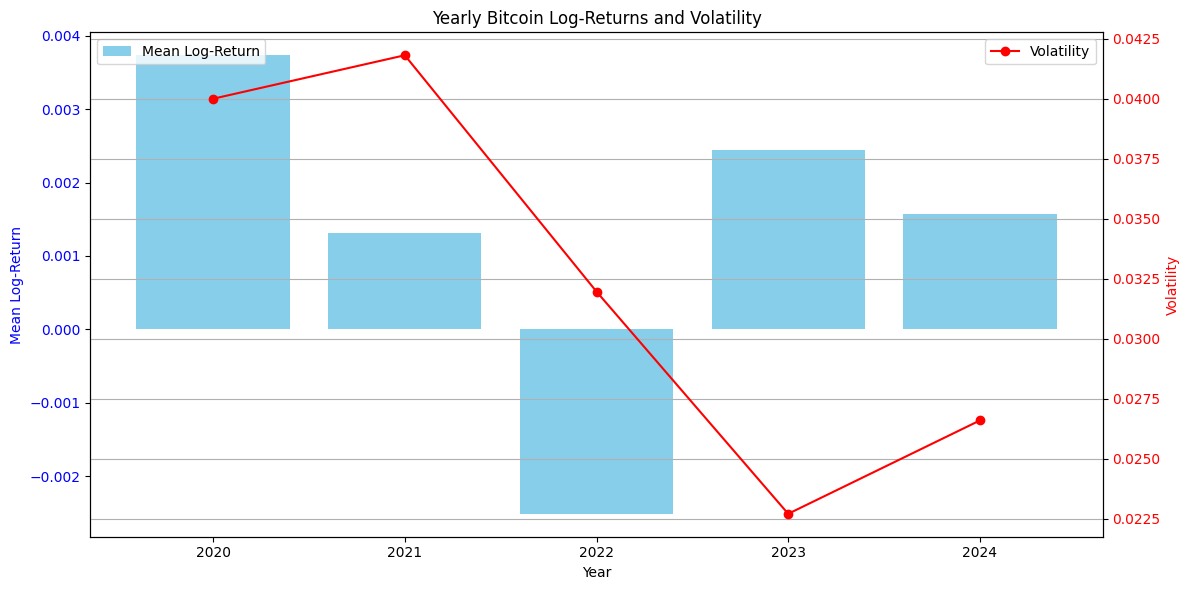

,Year,Mean_Log_Return,Volatility
0,2020,0.003737,0.039994
1,2021,0.001312,0.041805
2,2022,-0.002515,0.031963
3,2023,0.002440,0.022710
4,2024,0.001567,0.026598


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

file_path = '/content/BTC_Log_Returns_task_3.2.csv'
btc_data = pd.read_csv(file_path)

btc_data["Date"] = pd.to_datetime(btc_data["Date"])

btc_data["Year"] = btc_data["Date"].dt.year
yearly_stats = btc_data.groupby("Year")["Log_Return"].agg(["mean", "std"]).rename(
    columns={"mean": "Mean_Log_Return", "std": "Volatility"}
).reset_index()

# Plot yearly metrics
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(yearly_stats["Year"], yearly_stats["Mean_Log_Return"], color="skyblue", label="Mean Log-Return")
ax1.set_xlabel("Year")
ax1.set_ylabel("Mean Log-Return", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("Yearly Bitcoin Log-Returns and Volatility")

ax2 = ax1.twinx()
ax2.plot(yearly_stats["Year"], yearly_stats["Volatility"], color="red", marker="o", label="Volatility")
ax2.set_ylabel("Volatility", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid()
plt.show()

yearly_stats



# TASK 3.3

In [8]:
import pandas as pd
import csv

class Agent:
    def __init__(self, name, risk_tolerance, trade_frequency, initial_gbp=1000):
        self.name = name
        self.risk_tolerance = risk_tolerance  # Range: 0 (low) to 1 (high)
        self.trade_frequency = trade_frequency  # Number of trades per time period
        self.gbp_holdings = initial_gbp
        self.btc_holdings = 10
        self.total_wealth = initial_gbp
        self.previous_price = None  # To store the previous day's price

    def decide(self, market_data, day):

        price = market_data['Price'].iloc[day % len(market_data)]

        if self.trade_frequency > 0.5:  # High frequency
            decision = self.high_freq_strategy(price, day)
        else:  # Low frequency
            decision = self.low_freq_strategy(price, day)

        return decision

    def high_freq_strategy(self, price, day):
        # High frequency: react to small price changes or trends
        if self.previous_price is None:
            self.previous_price = price  # Initialize previous price on first day
            return "hold"  # No decision on the first day

        # High-frequency strategy (e.g., buy if price decreases, sell if price increases)
        if price < self.previous_price:
            self.previous_price = price
            return "buy"
        elif price > self.previous_price:
            self.previous_price = price
            return "sell"
        else:
            return "hold"  # If the price hasn't changed, hold

    def low_freq_strategy(self, price, day):
        # Low frequency: only trade if there's a strong price signal (e.g., after a significant drop or rise)
        if self.previous_price is None:
            self.previous_price = price
            return "hold"
        # Low-frequency strategy (e.g., buy if price has dropped significantly from a previous peak, sell if it's up)
        if price < self.previous_price * 0.95:
            self.previous_price = price
            return "buy"
        elif price > self.previous_price * 1.05:
            self.previous_price = price
            return "sell"
        else:
            return "hold"

    def trade(self, decision, price):

        if decision == "buy" and self.risk_tolerance > 0.5:
            if self.gbp_holdings >= price:
                self.gbp_holdings -= price
                self.btc_holdings += 1
                print(f"{self.name} is buying with higher risk on price {price}")
        elif decision == "buy" and self.risk_tolerance <= 0.5:
            print(f"{self.name} is avoiding high-risk buy on price {price}")
        elif decision == "sell" and self.risk_tolerance > 0.5:
            if self.btc_holdings > 0:
                self.btc_holdings -= 1
                self.gbp_holdings += price
                print(f"{self.name} is selling with higher risk on price {price}")
        else:
            print(f"{self.name} is being conservative and not selling on price {price}")

        # Update total wealth (GBP holdings + BTC holdings * current price)
        self.total_wealth = self.gbp_holdings + self.btc_holdings * price

class Market:
    def __init__(self, agents):
        self.agents = agents

    def simulate(self, market_data, days=1766):
        daily_log = []

        dates = pd.date_range(start=market_data['Date'].iloc[0], periods=days)

        for day in range(days):
            price = market_data['Price'].iloc[day % len(market_data)]
            current_date = dates[day]

            for agent in self.agents:
                decision = agent.decide(market_data, day)
                agent.trade(decision, price)

                daily_log.append({
                    'Date': current_date,
                    'Agent_Name': agent.name,
                    'Risk_Tolerance': agent.risk_tolerance,
                    'Trade_Frequency': agent.trade_frequency,
                    'Decision': decision,
                    'Price': price,
                    'Day': day,
                    'Total_Wealth': agent.total_wealth,
                    'GBP_Holdings': agent.gbp_holdings,
                    'BTC_Holdings': agent.btc_holdings
                })

            print(f"End of Day {day}: Market Price = {price}")
            print("------")

        with open('agent_decisions_task_3.3.csv', mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=daily_log[0].keys())
            writer.writeheader()
            writer.writerows(daily_log)

        print(f"Daily decisions and analysis saved to 'agent_decisions_task_3.3.csv'")

        log_df = pd.DataFrame(daily_log)
        log_df['Year'] = log_df['Date'].dt.year

        summary = log_df.groupby(['Year', 'Agent_Name']).agg(
            Total_Wealth=('Total_Wealth', 'last'),
            Average_Wealth=('Total_Wealth', 'mean'),
            Total_Buy_Decisions=('Decision', lambda x: (x == 'buy').sum()),
            Total_Sell_Decisions=('Decision', lambda x: (x == 'sell').sum()),
            Total_Hold_Decisions=('Decision', lambda x: (x == 'hold').sum()),
            Avg_Risk_Tolerance=('Risk_Tolerance', 'mean'),
            Avg_Trade_Frequency=('Trade_Frequency', 'mean')
        ).reset_index()

        summary.to_csv('yearly_summary_analysis_task_3.3.csv', index=False)
        print(f"Yearly summary saved to 'yearly_summary_analysis_task_3.3.csv'")

market_data = pd.DataFrame({
    'Date': pd.date_range(start="2020-01-01", periods=10, freq='D'),
    'Price': [100 + i * 2 for i in range(10)]
})

agents = [
    Agent(name="Agent1", risk_tolerance=0.8, trade_frequency=0.7),  # High risk, high frequency
    Agent(name="Agent2", risk_tolerance=0.3, trade_frequency=0.3),  # Low risk, low frequency
    Agent(name="Agent3", risk_tolerance=0.5, trade_frequency=0.5),  # Medium risk, medium frequency
]

market = Market(agents)

market.simulate(market_data, days=1766)


Streaming output truncated to the last 5000 lines.
Agent2 is being conservative and not selling on price 112
Agent3 is being conservative and not selling on price 112
End of Day 576: Market Price = 112
------
Agent2 is being conservative and not selling on price 114
Agent3 is being conservative and not selling on price 114
End of Day 577: Market Price = 114
------
Agent2 is being conservative and not selling on price 116
Agent3 is being conservative and not selling on price 116
End of Day 578: Market Price = 116
------
Agent2 is being conservative and not selling on price 118
Agent3 is being conservative and not selling on price 118
End of Day 579: Market Price = 118
------
Agent1 is buying with higher risk on price 100
Agent2 is avoiding high-risk buy on price 100
Agent3 is avoiding high-risk buy on price 100
End of Day 580: Market Price = 100
------
Agent1 is selling with higher risk on price 102
Agent2 is being conservative and not selling on price 102
Agent3 is being conservative a

# TASK 4.1

In [11]:
#run code 1.1 if this code gives "RSI 14 Days key error"
import pandas as pd

class ReinforcementLearningAgent:
    """Reinforcement Learning Agent based on Q-learning."""
    def __init__(self, name, epsilon=0.1, alpha=0.5, gamma=0.9):
        self.name = name
        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.q_table = {}  # State-action Q-table
        self.btc_holdings = INIT_BITCOIN
        self.gbp_holdings = INIT_GBP
        self.open_position = False
        self.position_btc = 0
        self.previous_state = None
        self.previous_action = None
        self.reward = 0
        self.history = []

    def get_state(self, price, rsi, momentum):
        """Define the state as a tuple of current price, RSI, and momentum."""
        return (price, rsi, momentum)

    def choose_action(self, state):
        """Choose an action based on epsilon-greedy policy."""
        if random.uniform(0, 1) < self.epsilon:
            action = random.choice(["buy", "sell", "hold"])
        else:
            # Initialize state if not in the Q-table
            if state not in self.q_table:
                self.q_table[state] = {"buy": 0, "sell": 0, "hold": 0}  # Initialize state-action pair
            action = max(self.q_table[state], key=self.q_table[state].get)  # Exploitation
        return action

    def update_q_table(self, state, action, reward, next_state):
        """Update Q-table based on the Q-learning update rule."""
        if state not in self.q_table:
            self.q_table[state] = {"buy": 0, "sell": 0, "hold": 0}
        if next_state not in self.q_table:
            self.q_table[next_state] = {"buy": 0, "sell": 0, "hold": 0}

        if action not in self.q_table[state]:
            raise ValueError(f"Action {action} not valid for state {state}")

        # Q-learning update
        max_future_q = max(self.q_table[next_state].values())
        current_q = self.q_table[state][action]
        self.q_table[state][action] = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)

    def trade(self, action, price):
        """Execute trades based on the chosen action."""
        if action == "buy" and not self.open_position:
            btc_bought = self.gbp_holdings / price
            self.position_btc = btc_bought
            self.btc_holdings += btc_bought
            self.gbp_holdings = 0
            self.open_position = True
        elif action == "sell" and self.open_position:
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False
        elif action == "hold":
            pass

    def decide_and_trade(self, day, price, rsi, momentum):
        """Decide whether to buy, sell, or hold based on Q-learning."""
        state = self.get_state(price, rsi, momentum)

        if state is None:
            raise ValueError("State is None!")

        # For the first round, we don't have a previous state or action yet.
        if self.previous_state is None or self.previous_action is None:
            action = self.choose_action(state)
        else:
            action = self.choose_action(state)

        # Execute the chosen action
        self.trade(action, price)

        # Calculate reward (profit/loss from the action taken)
        if self.open_position:
            reward = self.gbp_holdings + self.position_btc * price - INIT_GBP
        else:
            reward = self.gbp_holdings - INIT_GBP

        # Update Q-table based on the reward and the next state
        next_state = self.get_state(price, rsi, momentum)

        if self.previous_state is not None and self.previous_action is not None:
            self.update_q_table(self.previous_state, self.previous_action, reward, next_state)

        self.previous_state = state
        self.previous_action = action
        self.reward = reward

        self.history.append({
            'Day': day,
            'Action': action,
            'Price': price,
            'BTC_Holdings': self.btc_holdings,
            'GBP_Holdings': self.gbp_holdings,
            'Reward': reward
        })

def simulate_market_with_output(days=180):
    agent = ReinforcementLearningAgent(name="RL Agent")

    for day in range(14, days):  # Skip first 14 days for RSI calculation
        price = data['Price'].iloc[day]
        rsi = data['14-day RSI'].iloc[day]
        momentum = (data['Price'].iloc[day] - data['Price'].iloc[day-1]) / data['Price'].iloc[day-1]

        agent.decide_and_trade(day, price, rsi, momentum)

    history_df = pd.DataFrame(agent.history)
    history_df.to_csv('rl_agent_performance_task_4.1.csv', index=False)

simulate_market_with_output(180)

print("Simulation complete. Data saved to 'rl_agent_performance_task_4.1.csv'.")


Simulation complete. Data saved to 'rl_agent_performance_task_4.1.csv'.


# TASK 4.2

In [12]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
random.seed(42)
np.random.seed(42)

data = pd.read_csv('/content/BTC to GBP Historical Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.sort_values(by='Date', inplace=True)
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data = data[(data['Date'] >= '2020-01-01') & (data['Date'] <= '2024-11-01')]
data['Daily_Return'] = data['Price'].pct_change()
data['14-day RSI'] = 100 - (100 / (1 + data['Daily_Return'].rolling(14).mean() /
                                    abs(data['Daily_Return'].rolling(14).mean())))

NUM_AGENTS = 100
INIT_BITCOIN = 10
INIT_GBP = 10000
BITCOIN_ISSUANCE_INTERVAL = 90
BITCOIN_ISSUANCE_RATE = 0.1

agents = [{'GBP': INIT_GBP, 'BTC': INIT_BITCOIN, 'positions': []} for _ in range(NUM_AGENTS)]

class MarketEnvironment:
    """Simulates the market environment."""
    def __init__(self, agents, data):
        self.agents = agents
        self.data = data
        self.total_bitcoin = INIT_BITCOIN * len(agents)
        self.days = 0

    def distribute_new_bitcoin(self):
        """Distribute newly issued Bitcoin."""
        new_bitcoin = self.total_bitcoin * BITCOIN_ISSUANCE_RATE
        self.total_bitcoin += new_bitcoin
        total_agent_btc = sum(agent['BTC'] for agent in self.agents)
        for agent in self.agents:
            if total_agent_btc > 0:
                agent['BTC'] += new_bitcoin * (agent['BTC'] / total_agent_btc)

    def simulate_bitcoin_issuance(self):
        """Issue Bitcoin every 90 days."""
        if self.days > 0 and self.days % BITCOIN_ISSUANCE_INTERVAL == 0:
            self.distribute_new_bitcoin()

class Chartist:
    """Represents a Chartist agent."""
    def __init__(self, weight_momentum, weight_rsi, name):
        self.name = name
        self.weight_momentum = weight_momentum
        self.weight_rsi = weight_rsi
        self.open_position = False
        self.gbp_holdings = INIT_GBP
        self.btc_holdings = INIT_BITCOIN
        self.position_btc = 0
        self.positions_opened = 0
        self.positions_closed = 0

    def decide(self, price_data, day):
        """Decide to open or close a position."""
        if day < 14:
            return False, False
        momentum_signal = all(price_data['Price'].iloc[day-3:day].diff() > 0)
        rsi_signal = price_data['14-day RSI'].iloc[day]
        open_decision = momentum_signal if random.uniform(0, 1) < self.weight_momentum else rsi_signal < 30
        close_decision = not momentum_signal if random.uniform(0, 1) < self.weight_rsi else rsi_signal > 70
        return open_decision, close_decision

    def trade(self, open_decision, close_decision, price):
        """Execute trades."""
        if open_decision and not self.open_position:
            btc_bought = self.gbp_holdings / price
            self.btc_holdings += btc_bought
            self.position_btc = btc_bought
            self.gbp_holdings = 0
            self.open_position = True
            self.positions_opened += 1
        elif close_decision and self.open_position:
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False
            self.positions_closed += 1

class VolatilityBasedChartist(Chartist):
    """Represents a Volatility Based Chartist."""
    def __init__(self):
        super().__init__(weight_momentum=0.0, weight_rsi=0.0, name="Volatility Based")
        self.volatility_threshold = 2.5

    def decide(self, price_data, day):
        """Decide to open or close a position based on volatility."""
        if day < 14:
            return False, False

        volatility = price_data['Price'].iloc[day-7:day].pct_change().std()

        open_decision = volatility > self.volatility_threshold and not self.open_position
        close_decision = volatility < self.volatility_threshold and self.open_position

        return open_decision, close_decision

chartists = [
    Chartist(0.8, 0.2, 'Momentum Heavy'),
    Chartist(0.2, 0.8, 'RSI Heavy'),
    Chartist(0.5, 0.5, 'Balanced'),
    VolatilityBasedChartist()
]

class ReinforcementLearningAgent:
    """Reinforcement Learning Agent."""
    def __init__(self, name, epsilon=0.1, alpha=0.5, gamma=0.9):
        self.name = name
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = {}
        self.open_position = False
        self.gbp_holdings = INIT_GBP
        self.btc_holdings = INIT_BITCOIN
        self.position_btc = 0
        self.positions_opened = 0
        self.positions_closed = 0
        self.previous_state = None
        self.previous_action = None
        self.reward = 0

    def get_state(self, price, rsi, momentum):
        """Define state."""
        return (price, rsi, momentum)

    def choose_action(self, state):
        """Epsilon-greedy action selection."""
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(["buy", "sell", "hold"])
        if state not in self.q_table:
            self.q_table[state] = {"buy": 0, "sell": 0, "hold": 0}
        return max(self.q_table[state], key=self.q_table[state].get)

    def update_q_table(self, state, action, reward, next_state):
        """Q-table update."""
        if state not in self.q_table:
            self.q_table[state] = {"buy": 0, "sell": 0, "hold": 0}
        if next_state not in self.q_table:
            self.q_table[next_state] = {"buy": 0, "sell": 0, "hold": 0}
        max_future_q = max(self.q_table[next_state].values())
        self.q_table[state][action] += self.alpha * (reward + self.gamma * max_future_q - self.q_table[state][action])

    def trade(self, action, price):
        """Execute trades."""
        if action == "buy" and not self.open_position:
            btc_bought = self.gbp_holdings / price
            self.btc_holdings += btc_bought
            self.position_btc = btc_bought
            self.gbp_holdings = 0
            self.open_position = True
            self.positions_opened += 1
        elif action == "sell" and self.open_position:
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False
            self.positions_closed += 1

rl_agent = ReinforcementLearningAgent(name="RL Agent")

def simulate_market(days=1766):
    market = MarketEnvironment(agents, data)
    chartist_results = {chartist.name: {'positions_opened': 0, 'positions_closed': 0, 'final_gbp': 0, 'final_btc': 0} for chartist in chartists}
    rl_result = {'positions_opened': 0, 'positions_closed': 0, 'final_gbp': 0, 'final_btc': 0}

    for day in range(14, days):
        price = data['Price'].iloc[day]
        rsi = data['14-day RSI'].iloc[day]
        momentum = (data['Price'].iloc[day] - data['Price'].iloc[day - 1]) / data['Price'].iloc[day - 1]

        for chartist in chartists:
            open_decision, close_decision = chartist.decide(data, day)
            chartist.trade(open_decision, close_decision, price)

        state = rl_agent.get_state(price, rsi, momentum)
        action = rl_agent.choose_action(state)
        rl_agent.trade(action, price)

    for chartist in chartists:
        chartist_results[chartist.name]['positions_opened'] = chartist.positions_opened
        chartist_results[chartist.name]['positions_closed'] = chartist.positions_closed
        chartist_results[chartist.name]['final_gbp'] = chartist.gbp_holdings
        chartist_results[chartist.name]['final_btc'] = chartist.btc_holdings

    rl_result['positions_opened'] = rl_agent.positions_opened
    rl_result['positions_closed'] = rl_agent.positions_closed
    rl_result['final_gbp'] = rl_agent.gbp_holdings
    rl_result['final_btc'] = rl_agent.btc_holdings

    return chartist_results, rl_result

chartist_results, rl_result = simulate_market(180)

print("\n--- Chartist Summary ---")
for name, results in chartist_results.items():
    print(f"{name}:")
    print(f"  Positions Opened: {results['positions_opened']}")
    print(f"  Positions Closed: {results['positions_closed']}")
    print(f"  Final GBP: {results['final_gbp']:.2f}")
    print(f"  Final BTC: {results['final_btc']:.6f}")

print("\n--- RL Agent Summary ---")
print(f"Positions Opened: {rl_result['positions_opened']}")
print(f"Positions Closed: {rl_result['positions_closed']}")
print(f"Final GBP: {rl_result['final_gbp']:.2f}")
print(f"Final BTC: {rl_result['final_btc']:.6f}")



--- Chartist Summary ---
Momentum Heavy:
  Positions Opened: 8
  Positions Closed: 7
  Final GBP: 0.00
  Final BTC: 11.936076
RSI Heavy:
  Positions Opened: 26
  Positions Closed: 25
  Final GBP: 0.00
  Final BTC: 11.204382
Balanced:
  Positions Opened: 22
  Positions Closed: 21
  Final GBP: 0.00
  Final BTC: 11.316125
Volatility Based:
  Positions Opened: 0
  Positions Closed: 0
  Final GBP: 10000.00
  Final BTC: 10.000000

--- RL Agent Summary ---
Positions Opened: 8
Positions Closed: 7
Final GBP: 0.00
Final BTC: 11.530054


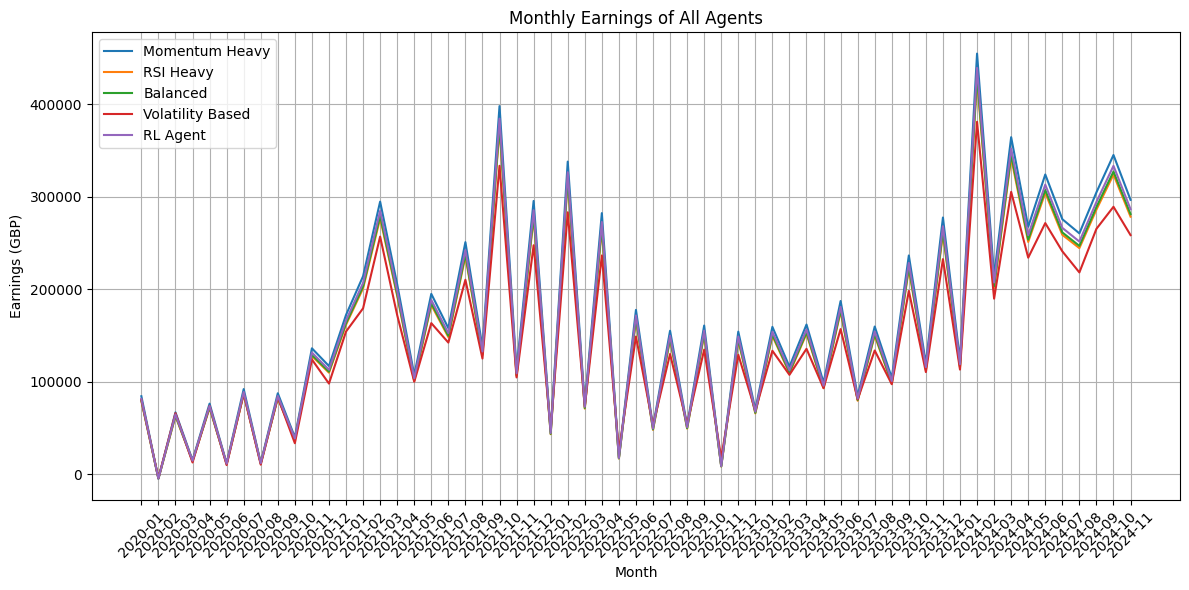

Monthly earnings saved to 'monthly_earnings_rl_task_4.2.csv'.


In [13]:

def compute_monthly_earnings(data, agents, rl_agent):
    data['Month'] = data['Date'].dt.to_period('M')
    monthly_data = data.groupby('Month').last().reset_index()

    monthly_earnings = {agent.name: [] for agent in chartists}
    monthly_earnings['RL Agent'] = []

    for i in range(len(monthly_data)):
        if i == 0:
            for chartist in chartists:
                monthly_earnings[chartist.name].append(
                    chartist.gbp_holdings + chartist.btc_holdings * monthly_data['Price'].iloc[i]
                )
            monthly_earnings['RL Agent'].append(
                rl_agent.gbp_holdings + rl_agent.btc_holdings * monthly_data['Price'].iloc[i]
            )
        else:
            for chartist in chartists:
                start_wealth = monthly_earnings[chartist.name][-1]
                end_wealth = chartist.gbp_holdings + chartist.btc_holdings * monthly_data['Price'].iloc[i]
                monthly_earnings[chartist.name].append(end_wealth - start_wealth)

            start_wealth_rl = monthly_earnings['RL Agent'][-1]
            end_wealth_rl = rl_agent.gbp_holdings + rl_agent.btc_holdings * monthly_data['Price'].iloc[i]
            monthly_earnings['RL Agent'].append(end_wealth_rl - start_wealth_rl)
    monthly_earnings_df = pd.DataFrame(monthly_earnings, index=monthly_data['Month'].astype(str))
    return monthly_earnings_df

monthly_earnings = compute_monthly_earnings(data, chartists, rl_agent)

def plot_monthly_earnings(monthly_earnings):
    plt.figure(figsize=(12, 6))
    for agent_name in monthly_earnings.columns:
        plt.plot(monthly_earnings.index, monthly_earnings[agent_name], label=agent_name)

    plt.title('Monthly Earnings of All Agents')
    plt.xlabel('Month')
    plt.ylabel('Earnings (GBP)')
    plt.legend(loc='best')
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_monthly_earnings(monthly_earnings)

def save_monthly_earnings_to_csv(monthly_earnings, filename='monthly_earnings_rl_task_4.2.csv'):
    monthly_earnings.to_csv(filename, index_label='Month')
    print(f"Monthly earnings saved to '{filename}'.")

save_monthly_earnings_to_csv(monthly_earnings, filename='monthly_earnings_rl_task_4.2.csv')



# TASK 4.3

In [15]:
import random
import pandas as pd


INIT_GBP = 10000
INIT_BITCOIN = 10
class Chartist:
    """Placeholder for Chartist class, will be similar to your existing chartist agent implementation."""
    def __init__(self, name, subtype):
        self.name = name
        self.subtype = subtype
        self.gbp_holdings = INIT_GBP
        self.btc_holdings = INIT_BITCOIN
        self.open_position = False
        self.position_btc = 0
        self.history = []
        self.exposure_time = 0

    def trade(self, action, price):
        """Perform trade actions (buy, sell, hold)."""
        if action == "buy" and not self.open_position:
            btc_bought = self.gbp_holdings / price
            self.position_btc = btc_bought
            self.btc_holdings += btc_bought
            self.gbp_holdings = 0
            self.open_position = True
            self.exposure_time = 0
            print(f"{self.name} bought {btc_bought} BTC at {price}")
        elif action == "sell" and self.open_position:
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False
            print(f"{self.name} sold BTC for {gbp_sold} GBP at {price}")
        elif action == "hold":
            print(f"{self.name} is holding position.")
            if self.open_position:
                self.exposure_time += 1
    def decide_and_trade(self, day, price, rsi, momentum):
        """Decide whether to buy, sell, or hold based on chartist strategy."""
        action = random.choice(["buy", "sell", "hold"])
        self.trade(action, price)
        total_wealth = self.gbp_holdings + (self.btc_holdings * price)

        reward = total_wealth - INIT_GBP
        self.history.append({
            'Date': pd.to_datetime('2020-01-01') + pd.to_timedelta(day, unit='D'),
            'Agent_Type': 'Chartist',
            'Subtype': self.subtype,
            'GBP_Holdings': self.gbp_holdings,
            'BTC_Holdings': self.btc_holdings,
            'Total_Wealth': total_wealth,
            'Exposure': self.open_position,
            'Reward': reward,
            'Exposure_Time': self.exposure_time,
            'Day': day
        })

class RandomTrader:
    """Placeholder for Random Trader class."""
    def __init__(self, name):
        self.name = name
        self.gbp_holdings = INIT_GBP
        self.btc_holdings = INIT_BITCOIN
        self.open_position = False
        self.position_btc = 0
        self.history = []
        self.exposure_time = 0

    def trade(self, action, price):
        """Perform trade actions (buy, sell, hold)."""
        if action == "buy" and not self.open_position:
            btc_bought = self.gbp_holdings / price
            self.position_btc = btc_bought
            self.btc_holdings += btc_bought
            self.gbp_holdings = 0
            self.open_position = True
            self.exposure_time = 0
            print(f"{self.name} bought {btc_bought} BTC at {price}")
        elif action == "sell" and self.open_position:
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False
            print(f"{self.name} sold BTC for {gbp_sold} GBP at {price}")
        elif action == "hold":
            print(f"{self.name} is holding position.")
            if self.open_position:
                self.exposure_time += 1

    def decide_and_trade(self, day, price, rsi, momentum):
        """Random action selection for Random Trader."""
        action = random.choice(["buy", "sell", "hold"])
        self.trade(action, price)
        total_wealth = self.gbp_holdings + (self.btc_holdings * price)
        reward = total_wealth - INIT_GBP
        self.history.append({
            'Date': pd.to_datetime('2020-01-01') + pd.to_timedelta(day, unit='D'),
            'Agent_Type': 'Random Trader',
            'Subtype': 'NaN',
            'GBP_Holdings': self.gbp_holdings,
            'BTC_Holdings': self.btc_holdings,
            'Total_Wealth': total_wealth,
            'Exposure': self.open_position,
            'Reward': reward,
            'Exposure_Time': self.exposure_time,
            'Day': day
        })

class ReinforcementLearningAgent:
    """Reinforcement Learning Agent based on Q-learning."""
    def __init__(self, name, epsilon=0.1, alpha=0.5, gamma=0.9):
        self.name = name
        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.q_table = {}  # State-action Q-table
        self.btc_holdings = INIT_BITCOIN
        self.gbp_holdings = INIT_GBP
        self.open_position = False
        self.position_btc = 0
        self.previous_state = None
        self.previous_action = None
        self.reward = 0
        self.history = []
        self.exposure_time = 0

    def get_state(self, price, rsi, momentum):
        """Define the state as a tuple of current price, RSI, and momentum."""
        return (price, rsi, momentum)

    def choose_action(self, state):
        """Choose an action based on epsilon-greedy policy."""
        if random.uniform(0, 1) < self.epsilon:
            action = random.choice(["buy", "sell", "hold"])
        else:
            if state not in self.q_table:
                self.q_table[state] = {"buy": 0, "sell": 0, "hold": 0}
            action = max(self.q_table[state], key=self.q_table[state].get)
        return action

    def update_q_table(self, state, action, reward, next_state):
        """Update Q-table based on the Q-learning update rule."""
        if state not in self.q_table:
            self.q_table[state] = {"buy": 0, "sell": 0, "hold": 0}
        if next_state not in self.q_table:
            self.q_table[next_state] = {"buy": 0, "sell": 0, "hold": 0}

        if action not in self.q_table[state]:
            raise ValueError(f"Action {action} not valid for state {state}")

        # Q-learning update
        max_future_q = max(self.q_table[next_state].values())
        current_q = self.q_table[state][action]
        self.q_table[state][action] = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)

    def trade(self, action, price):
        """Execute trades based on the chosen action."""
        if action == "buy" and not self.open_position:
            btc_bought = self.gbp_holdings / price
            self.position_btc = btc_bought
            self.btc_holdings += btc_bought
            self.gbp_holdings = 0
            self.open_position = True
            self.exposure_time = 0
        elif action == "sell" and self.open_position:
            gbp_sold = self.position_btc * price
            self.gbp_holdings += gbp_sold
            self.btc_holdings -= self.position_btc
            self.position_btc = 0
            self.open_position = False
        elif action == "hold":
            pass

    def decide_and_trade(self, day, price, rsi, momentum):
        """Decide whether to buy, sell, or hold based on Q-learning."""
        state = self.get_state(price, rsi, momentum)


        if self.previous_state is None or self.previous_action is None:
            action = self.choose_action(state)
        else:
            reward = self.reward
            self.update_q_table(self.previous_state, self.previous_action, reward, state)
            action = self.choose_action(state)

        self.trade(action, price)
        total_wealth = self.gbp_holdings + (self.btc_holdings * price)
        self.reward = total_wealth - INIT_GBP


        self.history.append({
            'Date': pd.to_datetime('2020-01-01') + pd.to_timedelta(day, unit='D'),
            'Agent_Type': 'RL Agent',
            'Subtype': 'NaN',
            'GBP_Holdings': self.gbp_holdings,
            'BTC_Holdings': self.btc_holdings,
            'Total_Wealth': total_wealth,
            'Exposure': self.open_position,
            'Reward': self.reward,
            'Exposure_Time': self.exposure_time,
            'Day': day
        })

        self.previous_state = state
        self.previous_action = action

def calculate_metrics(agent_history):
    """Calculate additional metrics: win rate, max drawdown, GBP-to-BTC ratio, exposure time, and total wealth."""
    history_df = pd.DataFrame(agent_history)


    profitable_trades = history_df[history_df['Reward'] > 0].shape[0]
    total_trades = history_df[history_df['Reward'] != 0].shape[0]
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0

    wealth_series = history_df['Total_Wealth']
    running_max = wealth_series.cummax()
    drawdown = running_max - wealth_series
    max_drawdown = drawdown.max()


    avg_gbp = history_df['GBP_Holdings'].mean()
    avg_btc = history_df['BTC_Holdings'].mean()
    gbp_to_btc_ratio = avg_gbp / avg_btc if avg_btc > 0 else float('inf')

    avg_total_wealth = history_df['Total_Wealth'].mean()

    avg_exposure_time = history_df['Exposure_Time'].mean()

    return win_rate, max_drawdown, gbp_to_btc_ratio, avg_total_wealth, avg_exposure_time

def simulate_market_with_output_with_metrics(days=180):

    chartists = [
        Chartist(name="Chartist", subtype="Momentum Heavy"),
        Chartist(name="Chartist", subtype="RSI Heavy"),
        Chartist(name="Chartist", subtype="Balanced"),
        Chartist(name="Chartist", subtype="Volatility Based")
    ]
    random_traders = [RandomTrader(name="Random Trader")]

    all_agents = chartists + random_traders + [ReinforcementLearningAgent(name="RL Agent")]

    for day in range(14, days):
        price = data['Price'].iloc[day]
        rsi = data['14-day RSI'].iloc[day]
        momentum = (data['Price'].iloc[day] - data['Price'].iloc[day - 1]) / data['Price'].iloc[day - 1]

        for agent in all_agents:
            agent.decide_and_trade(day, price, rsi, momentum)

    all_history = []
    metrics = []
    for agent in all_agents:
        agent_subtype = getattr(agent, 'subtype', 'NaN')
        win_rate, max_drawdown, gbp_to_btc_ratio, avg_total_wealth, avg_exposure_time = calculate_metrics(agent.history)
        metrics.append({
            'Agent_Name': f"{agent.name} ({agent_subtype})",  # Add subtype to agent name
            'Agent_Type': type(agent).__name__,
            'Win_Rate': win_rate,
            'Max_Drawdown': max_drawdown,
            'GBP_to_BTC_Ratio': gbp_to_btc_ratio,
            'Avg_Total_Wealth': avg_total_wealth,
            'Avg_Exposure_Time': avg_exposure_time
        })

        all_history.extend(agent.history)

    history_df = pd.DataFrame(all_history)
    metrics_df = pd.DataFrame(metrics)

    history_df.to_csv('all_agents_performance_task_4.3.csv', index=False)
    metrics_df.to_csv('all_agents_metrics_task_4.3.csv', index=False)

    print("Simulation complete. Performance data saved to 'all_agents_performance_task_4.3.csv'.")
    print("Agent metrics saved to 'all_agents_metrics_task_4.3.csv'.")

simulate_market_with_output_with_metrics(1766)


Streaming output truncated to the last 5000 lines.
Chartist bought 0.7196224314746019 BTC at 8088.7
Chartist sold BTC for 12076.398785811596 GBP at 8088.7
Random Trader bought 1.2871552122704344 BTC at 8088.7
Chartist is holding position.
Chartist sold BTC for 10611.733764840128 GBP at 8328.4
Random Trader is holding position.
Chartist sold BTC for 6039.9349918526295 GBP at 8393.2
Chartist bought 1.43883129030782 BTC at 8393.2
Chartist bought 1.264325139975233 BTC at 8393.2
Random Trader is holding position.
Chartist is holding position.
Chartist is holding position.
Chartist bought 0.7152338143276409 BTC at 8444.7
Chartist sold BTC for 12150.498597262449 GBP at 8444.7
Chartist is holding position.
Random Trader sold BTC for 10869.639621060138 GBP at 8444.7
Chartist is holding position.
Chartist sold BTC for 14356.596026247073 GBP at 8472.2
Chartist is holding position.
Chartist sold BTC for 10711.61545089817 GBP at 8472.2
Random Trader is holding position.
Chartist sold BTC for 6148.6